In [1]:
%matplotlib inline

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import xarray as xr
import dask

sns.set_context('talk')

# Multivariate Data

In [2]:
np.random.seed(0)

n_obs = 100
x = sns.distributions.stats.uniform(loc=-.5).rvs(size=n_obs) * 5.
y = x**2 + 1 + sns.distributions.stats.norm.rvs(scale=2, size=n_obs)

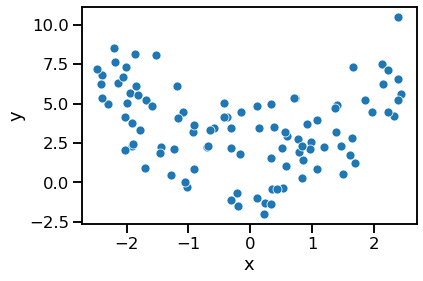

In [3]:
sns.scatterplot(x, y)
plt.ylabel('y')
plt.xlabel('x');
plt.savefig('../img/5_multivariate_data_1.svg', bbox_inches='tight', pad_inches=.1)

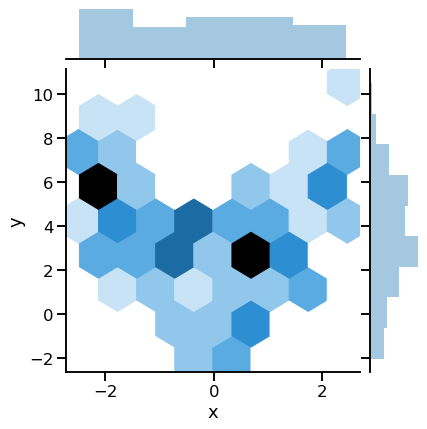

In [4]:
sns.jointplot(x, y, kind='hex').set_axis_labels('x', 'y');
plt.savefig('../img/5_multivariate_data_2.svg', bbox_inches='tight', pad_inches=.1)

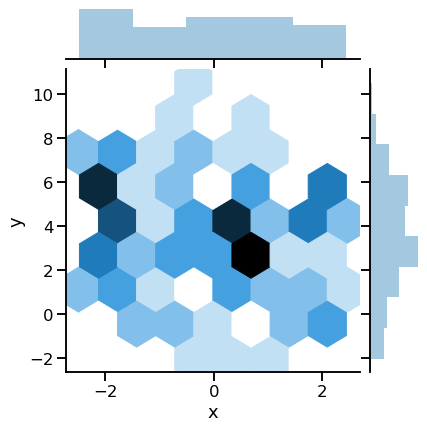

In [5]:
sns.jointplot(x, np.random.permutation(y), kind='hex').set_axis_labels('x', 'y');
plt.savefig('../img/5_multivariate_data_3.svg', bbox_inches='tight', pad_inches=.1)

## The mean

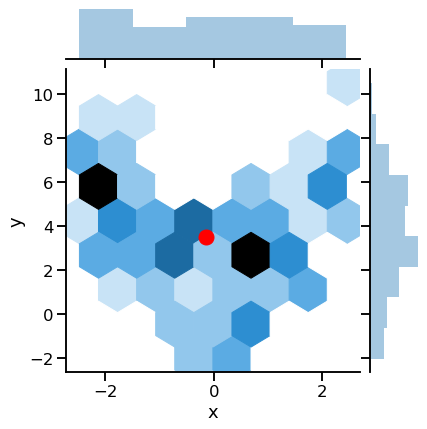

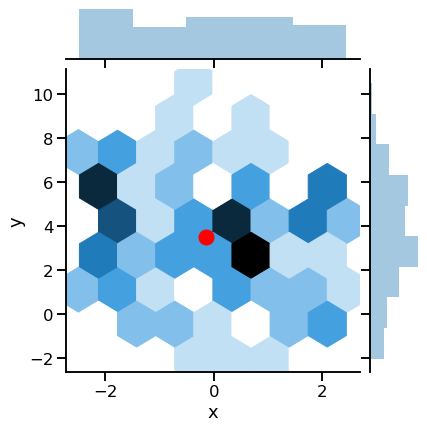

In [6]:
np.random.seed(0)

n_obs = 100
x = sns.distributions.stats.uniform(loc=-.5).rvs(size=n_obs) * 5.
y = x**2 + 1 + sns.distributions.stats.norm.rvs(scale=2, size=n_obs)

h = sns.jointplot(x, y, kind='hex').set_axis_labels('x', 'y');
h.ax_joint.plot(x.mean(), y.mean(), 'ro', markersize=15)
plt.savefig('../img/5_multivariate_data_mean_1.svg', bbox_inches='tight', pad_inches=.1)

y = np.random.permutation(y)
h = sns.jointplot(x, y, kind='hex').set_axis_labels('x', 'y');
h.ax_joint.plot(x.mean(), y.mean(), 'ro', markersize=15);
plt.savefig('../img/5_multivariate_data_mean_2.svg', bbox_inches='tight', pad_inches=.1)

## Independent variables

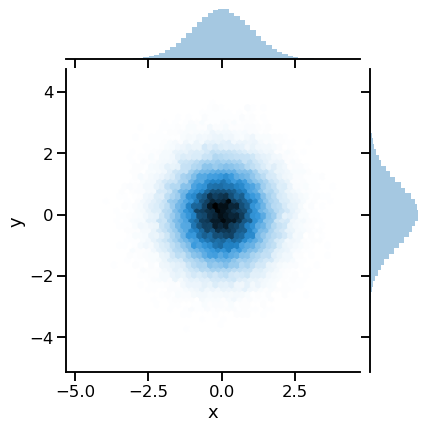

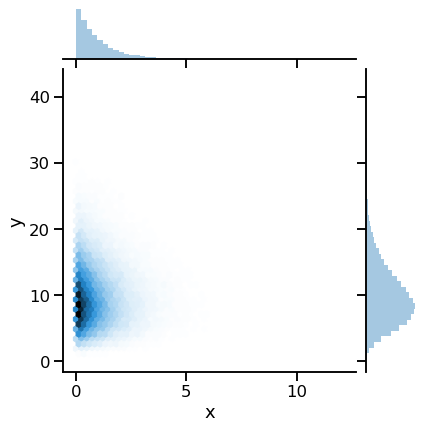

In [7]:
np.random.seed(0)
n_obs = 100000

distr_x = (sns.distributions.stats.norm, sns.distributions.stats.expon)
distr_y = (sns.distributions.stats.norm, sns.distributions.stats.chi2(df=10))

for i, (d_x, d_y) in enumerate(zip(distr_x, distr_y)):
    x = d_x.rvs(size=n_obs)
    y = d_y.rvs(size=n_obs)
    
    sns.jointplot(x, y, kind='hex', rasterized=True).set_axis_labels('x', 'y')
    plt.savefig('../img/5_independence_{}.svg'.format(i+1), bbox_inches='tight', pad_inches=.1)
    

## Covariance

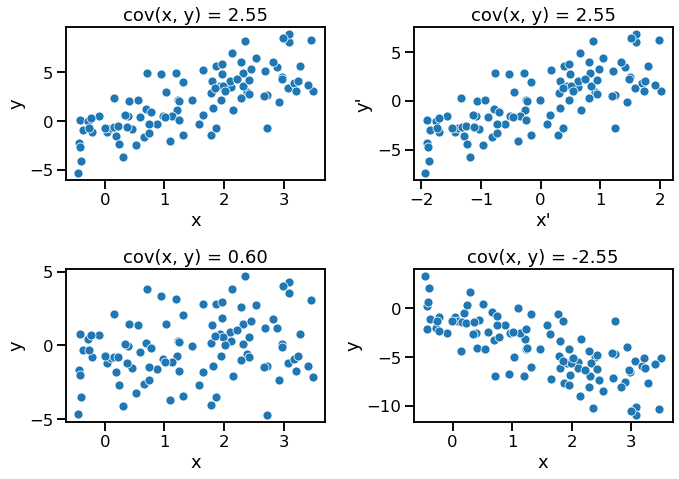

In [8]:
np.random.seed(0)
n_obs = 100

distr_x = sns.distributions.stats.uniform(loc=-.5, scale=4.)
distr_y_nois = sns.distributions.stats.norm(scale=2.)

noise = distr_y_nois.rvs(size=n_obs)

x = distr_x.rvs(size=n_obs)
y1 = 2 * x - 1 + noise
y2 = .5 * x - 1 + noise
y3 = -2 * x - 1 - noise

plt.figure(figsize=(10, 7))

for i, y in enumerate((y1, y1 - y1.mean(), y2, y3)):
    plt.subplot(2, 2, i + 1)
    if i == 1:
        plt.xlabel("x'"); plt.ylabel("y'");
        x_data = x - x.mean()
    else:
        plt.xlabel('x'); plt.ylabel('y');
        x_data = x
    sns.scatterplot(x_data, y);
    plt.title(
        "cov(x, y) = {:4.2f}".format(np.cov(x, y)[1, 0]),
    );

plt.tight_layout()

plt.savefig('../img/5_covariance_1.svg', bbox_inches='tight', pad_inches=.1)

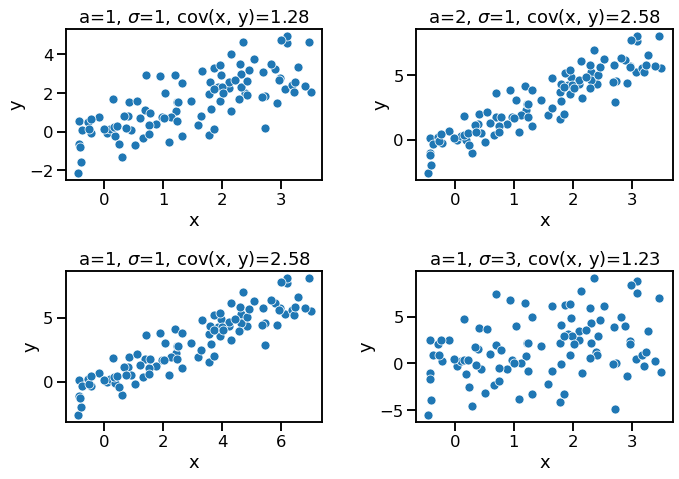

In [9]:
np.random.seed(0)
n_obs = 100

distr_x = sns.distributions.stats.uniform(loc=-.5, scale=4.)
distr_y_nois = sns.distributions.stats.norm()

noise = distr_y_nois.rvs(size=n_obs)

x_data = distr_x.rvs(size=n_obs)
a = (1, 2, 1, 1)
sigma = (1, 1, 1, 3)

plt.figure(figsize=(10, 7))

for i, (x_fac, fac, s) in enumerate(
    zip(
        (1, 1, 2, 1),
        a,
        sigma
    )
):
    y = fac * x_fac * x + s * noise
    plt.subplot(2, 2, i + 1)
    plt.xlabel('x'); plt.ylabel('y');
    sns.scatterplot(x_fac * x, y);
    plt.title(
        r"a={}, $\sigma$={}, cov(x, y)={:4.2f}".format(fac, s, np.cov(x, y)[1, 0]),
    );

plt.tight_layout()

plt.savefig('../img/5_covariance_2.svg', bbox_inches='tight', pad_inches=.1)

## Correlation

In [10]:
np.random.seed(1)

n_ts = 2500
n_obs = 100
norm = sns.distributions.stats.norm()
noise = norm.rvs((n_obs, n_ts))
p = .9

x = np.empty_like(noise)
x[0] = 0

for i in range(1, n_obs):
    x[i] = x[i-1] * p + noise[i]

z_score = (x - x.mean(axis=0)) / x.std(axis=0, ddof=1)

corr = (z_score * z_score.T[..., np.newaxis]).sum(axis=-2) / (n_obs - 1)

corr = np.ma.array(corr)
corr.mask = np.eye(n_ts)

In [11]:
i_90 = np.unravel_index(np.ma.argmin(np.ma.abs(corr - .9)), corr.shape)
i_60 = np.unravel_index(np.ma.argmin(np.ma.abs(corr - .6)), corr.shape)
i_30 = np.unravel_index(np.ma.argmin(np.ma.abs(corr - .3)), corr.shape)
i_00 = np.unravel_index(np.ma.argmin(np.ma.abs(corr - .0)), corr.shape)

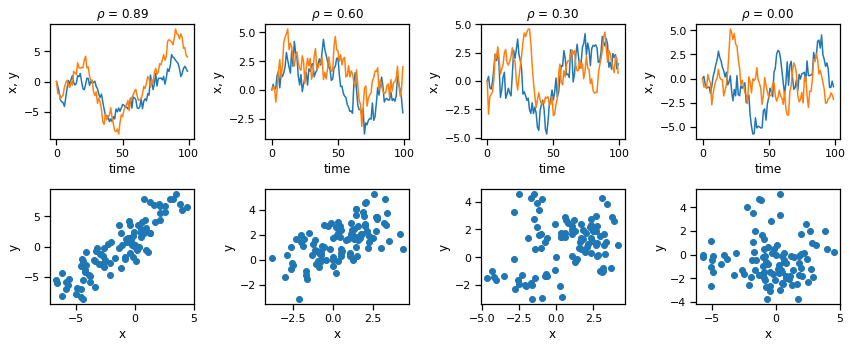

In [12]:
sns.set_context('notebook')

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(12, 5))

time = np.arange(n_obs)

for i, ind in enumerate((i_90, i_60, i_30, i_00)):
    ax1 = axs[0, i]
    ax1.plot(time, x[:, ind])
    ax1.set_title(r'$\rho$ = {:4.2f}'.format(corr[ind]))
    ax1.set_xlabel('time')
    ax1.set_ylabel('x, y')

    ax2 = axs[1, i]
    ax2.scatter(x[:, ind[0]], x[:, ind[1]])
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    
plt.tight_layout();
plt.savefig('../img/5_correlation_time_series.svg', bbox_inches='tight', pad_inches=.1)

## Point-to-Point correlation

Data: slp and surface air temperatur from NCEP

In [2]:
slp = xr.open_dataset('../data/slp.mon.mean.nc').slp
t_surf = xr.open_dataset('../data/air.mon.mean.nc').air

slp_month_group = slp.groupby("time.month")
slp_anomaly = slp_month_group - slp_month_group.mean("time")

t_surf_group = t_surf.groupby("time.month")
t_surf_anomaly = t_surf_group - t_surf_group.mean("time")

In [3]:
t = t_surf_anomaly.stack(space1=('lat', 'lon')).chunk({'space1': 100})
s = slp_anomaly.stack(space1=('lat', 'lon')).chunk({'space1': 100})

In [4]:
t_norm = ((t - t.mean('time')) / t.std(dim='time', ddof=1)).compute()
s_norm = ((s - s.mean('time')) / s.std(dim='time', ddof=1)).compute()

In [6]:
p2p_corr = (
    (t_norm * s_norm).sum('time')
    / (len(s_norm.time) - 1)
).unstack('space1').compute()

<ipython-input-7-e07b788bd180>:7: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


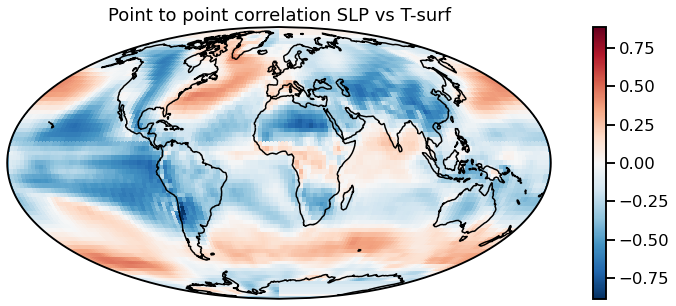

In [7]:
ax = plt.axes(projection=ccrs.Mollweide())
p2p_corr.plot(transform=ccrs.PlateCarree(), rasterized=True)
ax.coastlines()
plt.title("Point to point correlation SLP vs T-surf")

plt.gcf().set_size_inches(15., 5)
plt.tight_layout()
plt.savefig('../img/5_p2p_correlation.svg', bbox_inches='tight', pad_inches=.1)

## Box correlation

SST (NOAA OI V2) vs 500 hPa geopotential height (NCEP/NCAR Reanalysis)

In [52]:
sst = xr.open_dataset('../data/sst.mnmean.nc')
ls_mask = xr.open_dataset('../data/lsmask.nc').mask.isel(time=0)
hgt = xr.open_dataset('../data/hgt500.mon.mean.nc').rename({'lat': 'lat_hgt', 'lon': 'lon_hgt'})

# merge data to only have overlapping time
data = xr.merge([sst.where(ls_mask==1), hgt], join='inner')

In [56]:
# remove climatology
data_group = data.groupby('time.month')
data_anom = data_group - data_group.mean('time')

/home/mclaus/anaconda3/envs/climdat/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [57]:
hgt_norm = (data_anom.hgt - data_anom.hgt.mean('time')) / data_anom.hgt.std(dim='time', ddof=1).compute()
sst_norm = (data_anom.sst - data_anom.sst.mean('time')) / data_anom.sst.std(dim='time', ddof=1).compute()

/home/mclaus/anaconda3/envs/climdat/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/mclaus/anaconda3/envs/climdat/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


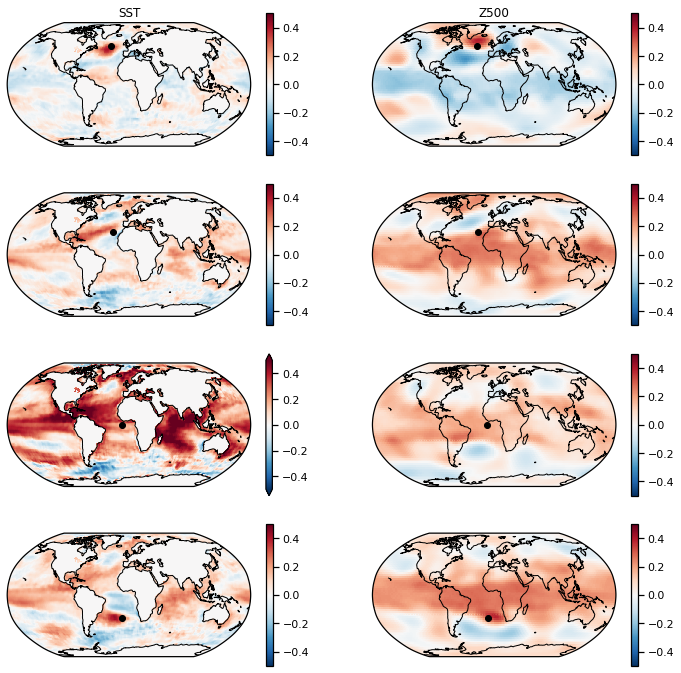

In [58]:
locations = (
    (50, 360-30),
    (30, 360-25),
    (0, 360-10),
    (-30, 360-10)
)

plt_args = {"transform": ccrs.PlateCarree(), 'vmin': -.5, 'vmax': .5, 'cmap': 'RdBu_r', "rasterized":True}

for i, loc in enumerate(locations):
    plt.subplot(4, 2, 2*i+1, projection=ccrs.Robinson())
    corr = (sst_norm * hgt_norm.sel(lat_hgt=loc[0], lon_hgt=loc[1], method='nearest')).sum('time') / (sst_norm.sizes['time'] - 1)
    corr.plot(
        **plt_args
    )
#     plt.clim(-1, 1)
    plt.scatter(loc[1], loc[0], transform=ccrs.PlateCarree(), c='k')
    plt.gca().coastlines()
    if i==0:
        plt.title("SST")
    else:
        plt.title("")
        
    plt.subplot(4, 2, 2*(i+1), projection=ccrs.Robinson())
    corr = (sst_norm.sel(lat=loc[0], lon=loc[1], method='nearest') * hgt_norm).sum('time') / (hgt_norm.sizes['time'] - 1)
    corr.plot(
        **plt_args
    )
#     plt.clim(-1, 1)
    plt.scatter(loc[1], loc[0], transform=ccrs.PlateCarree(), c='k')
    plt.gca().coastlines()
    if i==0:
        plt.title("Z500")
    else:
        plt.title("")
    
plt.gcf().set_size_inches(12, 12)
# plt.tight_layout()
plt.savefig('../img/5_box_correlations.svg', bbox_inches='tight', pad_inches=.1)

## Teleconnections

Nino 3.4 index (NOAA OI V2) vs SST (NOAA OI V2)

In [68]:
sst = xr.open_dataset('../data/sst.mnmean.nc').sst
ls_mask = xr.open_dataset('../data/lsmask.nc').mask.isel(time=0)

sst = sst.where(ls_mask==1)

In [74]:
sst_group = sst.groupby('time.month')
sst_climatology = sst_group.mean('time')

/home/mclaus/anaconda3/envs/climdat/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [75]:
sst_anom = sst_group - sst_climatology

In [95]:
nino_34_sst = sst_anom.sel(lon=slice(360-170, 360-120), lat=slice(5, -5)).mean(dim=('lat', 'lon'))

In [99]:
nino_34 = nino_34_sst.rolling(time=5, center=True).mean()
nino_34 = (nino_34 - nino_34.mean()) / nino_34.std(ddof=1)

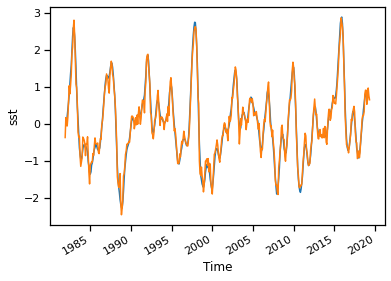

In [101]:
nino_34.plot()
nino_34_sst.plot()

In [102]:
sst_norm = (sst_anom - sst_anom.mean('time')) / sst_anom.std('time', ddof=1)

/home/mclaus/anaconda3/envs/climdat/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/mclaus/anaconda3/envs/climdat/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [103]:
corr = (sst_norm * nino_34).sum('time') / (nino_34.sizes['time'] - 1)

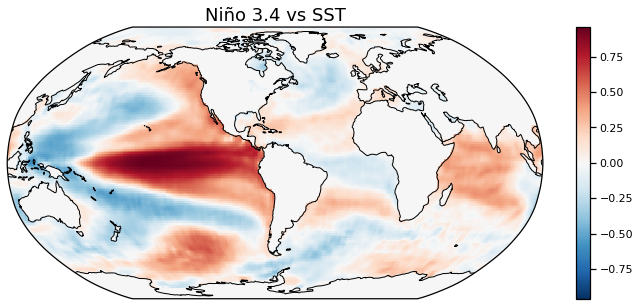

In [131]:
ax = plt.subplot(projection=ccrs.Robinson(central_longitude=-70))
corr.plot(transform=ccrs.PlateCarree(), rasterized=True)
ax.coastlines()

plt.title("Niño 3.4 vs SST", fontsize=18)

plt.gcf().set_size_inches(12, 5)
plt.savefig('../img/5_nino_34_correlation.svg', bbox_inches='tight', pad_inches=.1)